In [2]:
# imports and drive mount
import numpy as np
import random
import matplotlib.pyplot as plt
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from sklearn.utils import shuffle
from google.colab import drive
import seaborn as sn
from sklearn.metrics import confusion_matrix
drive.mount('/content/drive')

# Enable inline plotting
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# imports for keras layers and plot libs
from keras.datasets import cifar10
from keras.models import load_model
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
import seaborn as sns
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.layers import Dense, Conv2D, Flatten, Input, AvgPool2D,MaxPool2D,Dropout,BatchNormalization,GlobalAveragePooling2D
from keras.utils import to_categorical
from keras import regularizers
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


# UAP setups

In [4]:
def untargetedUAP( model, train_set, true_labels,iterations, epsilon, step):
  input_shape = train_set.shape[1:]
 
  # Vars
  img = tf.placeholder(tf.float32, shape=input_shape)
  target = tf.placeholder(tf.float32, (1,true_labels.shape[1]))
  global_uap = tf.Variable(np.zeros(input_shape, dtype=np.float32))
  perturbation = tf.Variable(np.zeros(input_shape, dtype=np.float32))

  # graph
  x_adv = img + global_uap + perturbation
  x_adv = tf.clip_by_value(x_adv,0,1)
  prediction = model(tf.reshape(x_adv, (1,32,32,3)))
  loss = keras.losses.categorical_crossentropy(target, prediction)
  grad = tf.gradients(loss, perturbation)

  # initialization:
  old_vars = set(x.name for x in tf.global_variables())
  new_vars = [x for x in tf.global_variables() if x.name not in old_vars]
  _global_uap = np.zeros(input_shape)
  sess.run(tf.initialize_variables([global_uap] + new_vars))
  
  #running the attack
  for epoch in range(10):
    EarlyStop = 1
    # iterating each sample
    for i in range(train_set.shape[0]):
      init_new_vars_op = tf.initialize_variables([perturbation])
      sess.run(init_new_vars_op)
      pred = model.predict((train_set[i] + _global_uap).reshape((1,32,32,3)))
      if np.argmax(pred) == np.argmax(true_labels[i]): #need update
        for _ in range(iterations):
          _grad, _perturbation, _prediction, _loss = sess.run([grad, perturbation, prediction, loss], {img: train_set[i],
                                                                                                      target: true_labels[i:i+1]})
          perturbation.load((_perturbation + np.sign(_grad)*step).reshape(input_shape),sess)
          if np.argmax(_prediction[0]) != np.argmax(true_labels[i]): # update success
              _global_uap += _perturbation
              _global_uap = L2_projection(_global_uap, epsilon)
              global_uap.load(_global_uap, sess)
              EarlyStop = 0 
              break
    _fool_rate, _uap_size = eval_uap(model, train_set, true_labels, _global_uap)
    print(f'Epoch: {epoch+1},\n'
          f'Fooling rate: {_fool_rate}, UAP Size: {_uap_size}')          
    if EarlyStop:
      break

  return _global_uap

In [5]:
def targetedUAP(model, train_set, target_labels, iterations, epsilon, step):
  input_shape = train_set.shape[1:]

  img = tf.placeholder(tf.float32, shape=input_shape)
  target = tf.placeholder(tf.float32, (1,target_labels.shape[1]))
  global_uap = tf.Variable(np.zeros(input_shape, dtype=np.float32))
  perturbation = tf.Variable(np.zeros(input_shape, dtype=np.float32))

  x_adv = img + global_uap + perturbation
  x_adv = tf.clip_by_value(x_adv,0,1)
  prediction = model(tf.reshape(x_adv, (1,32,32,3)))
  loss = keras.losses.categorical_crossentropy(target, prediction)
  grad = tf.gradients(loss, perturbation)

  # initialization:
  old_vars = set(x.name for x in tf.global_variables())
  new_vars = [x for x in tf.global_variables() if x.name not in old_vars]
  _global_uap = np.zeros(input_shape)
  sess.run(tf.initialize_variables([global_uap] + new_vars))
  
  #running the attack
  train_acc = 0
  for epoch in range(1):
    if train_acc>0.7:
      break
    for i in range(train_set.shape[0]):
      init_new_vars_op = tf.initialize_variables([perturbation])
      sess.run(init_new_vars_op)
      pred = model.predict((train_set[i] + _global_uap).reshape((1,32,32,3)))
      if np.argmax(pred) != np.argmax(target_labels[i]):
        for _ in range(iterations):
          _grad, _perturbation, _prediction, _loss = sess.run([grad, perturbation, prediction, loss], {img: train_set[i],
                                                                                                      target: target_labels[i:i+1]})
          perturbation.load((_perturbation - np.sign(_grad)*step).reshape(input_shape),sess)
          if np.argmax(_prediction, axis=-1)[0] == np.argmax(target_labels, axis=-1)[i]:
              _global_uap += _perturbation
              _global_uap = L2_projection(_global_uap, epsilon)
              global_uap.load(_global_uap, sess)
              break
    _fool_rate, _uap_size = eval_uap(model, train_set, target_labels, _global_uap)
    train_acc = 1-_fool_rate
    print(f'Epoch: {epoch+1},\n'
          f'Moved into target class: {train_acc},\n'
          f'UAP Size: {_uap_size}')           
    

  return _global_uap

In [6]:
def eval_uap(model, test_img, test_labels, uap):
  score = model.evaluate(test_img+uap, test_labels, verbose=0)
  L2_uap_size = np.sqrt(np.sum((uap*uap)))
  return 1-score[1], L2_uap_size

def eval_targeted_uap(model,adv_images,true_labels,target_labels):
  score = model.evaluate(adv_images, true_labels, verbose=0)
  fooling_rate = (1-score[1])
  score = model.evaluate(adv_images, target_labels, verbose=0)
  targeted_acc = score[1]
  return fooling_rate, targeted_acc
  
def getPermutation(labels, num_classes):
  permutation = np.argmax(labels, axis=-1)
  permutation = (permutation + 1) % (num_classes)
  return keras.utils.to_categorical(permutation, num_classes)

def L2_projection(perturbation, epsilon):
  norm = np.sum(np.square(perturbation))
  norm = np.sqrt(np.maximum(10e-12, norm))
  factor = np.minimum(1, np.divide(epsilon, norm))
  return perturbation*factor

In [7]:
''' Normalize input to the range of [0..1]
    Apart from assisting in the convergance of the training process, this 
    will also make our lives easier during the adversarial attack process
'''
def normalize(x_train,x_test):
    x_train -= x_train.min()
    x_train /= x_train.max()
    x_test -= x_test.min()
    x_test /= x_test.max()
    
    return x_train, x_test

''' A simple utility funcion for evaluating the success of an attack
'''
def TestAttack(model, adv_images, orig_images, true_labels, target_labels=None, targeted=False):
    score = model.evaluate(adv_images, true_labels, verbose=0)
    print('Test loss: {:.2f}'.format(score[0]))
    print('Successfully moved out of source class: {:.2f}'.format( 1 - score[1]))
    
    if targeted:
        score = model.evaluate(adv_images, target_labels, verbose=0)
        print('Test loss: {:.2f}'.format(score[0]))
        print('Successfully perturbed to target class: {:.2f}'.format(score[1]))
    
    dist = np.mean(np.sqrt(np.mean(np.square(adv_images - orig_images), axis=(1,2,3))))
    print('Mean perturbation distance: {:.2f}'.format(dist))
    
    index = 10
    img = adv_images[index].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()

In [8]:
def splitByClass(X,Y, nTrain):
  img_train, img_val, y_train, y_val =[],[],[],[]
  for i in range(10):
    labels = np.argmax(Y,axis=-1)
    class_img = X[np.where(labels[:]==i)]
    class_labels = keras.utils.to_categorical(labels[np.where(labels[:]==i)],10)
    img_train.append(class_img[:nTrain])
    img_val.append(class_img[nTrain:])
    y_train.append(class_labels[:nTrain])
    y_val.append(class_labels[nTrain:])
  return img_train,img_val,y_train,y_val




In [23]:
def getEvalData(x,y,toRemove):
  res_x, res_y = [],[]
  for i in range(x.shape[0]):
    if y[i]!=toRemove:
      res_x.append(x[i])
      res_y.append(y[i])
  return np.array(res_x,dtype=np.float32), np.array(res_y,dtype=np.float32)

In [9]:
def plot_multiple_imgs(X,y,nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0):
    fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=figsize)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(nrow*ncol):
        ax[i//ncol,i%ncol].imshow(X[skip+i],cmap='binary')
        ax[i//ncol,i%ncol].set_xticks([])
        ax[i//ncol,i%ncol].set_yticks([])
        if preds is not None:
            ax[i//ncol,i%ncol].text(0.85, 0.1, str(preds[skip+i]), transform=ax[i//ncol,i%ncol].transAxes,
                                   color='green' if y[skip+i]==preds[skip+i] else 'red',weight='bold')
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
        else:
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
    plt.show()

In [10]:
def targetedUAP2(model, train_set, target_labels,batch_size, iterations, epsilon, step):
  input_shape = (batch_size,32,32,3)

  batch_img = tf.placeholder(tf.float32, shape=input_shape)
  target = tf.placeholder(tf.float32, (batch_size,10))
  global_uap = tf.Variable(np.zeros((1,32,32,3), dtype=np.float32))
  perturbation = tf.Variable(np.zeros((1,32,32,3), dtype=np.float32))

  x_adv = batch_img + (global_uap + perturbation)
  x_adv = tf.clip_by_value(x_adv,0,1)
  prediction = model(x_adv)
  loss = keras.losses.categorical_crossentropy(target, prediction)
  grad = tf.gradients(loss, perturbation)

  # initialization:
  old_vars = set(x.name for x in tf.global_variables())
  new_vars = [x for x in tf.global_variables() if x.name not in old_vars]
  _global_uap = np.zeros((1,32,32,3))
  sess.run(tf.initialize_variables([global_uap] + new_vars))
  
  #running the attack
  train_acc = 0
  for epoch in range(5):
    if train_acc>0.95:
      break
    for i in range(int(train_set.shape[0]/batch_size)-2):
      start = i*batch_size
      batch = train_set[start:start+batch_size,:,:,:]
      batch_labels = target_labels[start:start+batch_size,:]
      init_new_vars_op = tf.initialize_variables([perturbation])
      sess.run(init_new_vars_op)
      for _ in range(iterations):
        _grad, _perturbation, _prediction, _loss = sess.run([grad, perturbation, prediction, loss], {batch_img: batch,
                                                                                                    target: batch_labels})
        perturbation.load((_perturbation - np.sign(_grad)*step).reshape((1,32,32,3)),sess)
      # update global uap
      _global_uap += _perturbation
      _global_uap = L2_projection(_global_uap, epsilon)
      global_uap.load(_global_uap, sess)
            
    _fool_rate, _uap_size = eval_uap(model, train_set, target_labels, _global_uap)
    train_acc = 1-_fool_rate
    print(f'Epoch: {epoch+1},\n'
          f'Moved into target class: {train_acc},\n'
          f'UAP Size: {_uap_size}')           
    

  return _global_uap

# Setup for CIFAR 10 dataset and model


## build and train CNN model

In [12]:
np.random.seed(0)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols, img_colors = 32, 32, 3
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_colors)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, img_colors)
x_train, x_test = normalize(x_train, x_test)
    

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
# upgrade 2  aug + batch normalization
dataAug = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
    )
dataAug.fit(x_train)

def build_cifar_model():
    model = Sequential()
    model.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())

    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())

    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())

    model.add(Flatten())
    model.add(Dense(10,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

model = build_cifar_model()
history = model.fit_generator(dataAug.flow(x_train, to_categorical(y_train), batch_size=32,shuffle = True),
                    steps_per_epoch=len(x_train) / 32, epochs=30, validation_data = ( x_test, to_categorical(y_test) ))


In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/Adversarial - Ziv Katzir/model.h5')
print("Saved model to disk")

## Experiment 1 
testing our targeted UAP variant:
1.   creating TUAP for each class
2.   visuelize its fooling effect




In [13]:
# Load the pre traind cnn model

sess = tf.Session()
keras.backend.set_session(sess)
init = tf.global_variables_initializer()
sess.run(init)
# load model
model = load_model('/content/drive/My Drive/Colab Notebooks/Adversarial - Ziv Katzir/model.h5')
# summarize model.
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_____________________________________

In [ ]:
# the model obtain 83% accuracy on the test set
model.evaluate(x_test, to_categorical(y_test))

10000/10000 [==============================] - 7s 725us/step


[0.5403337975978851, 0.8335000276565552]

now we create targeted uap for each potential class 

In [15]:
# split the dataset to 10 classes to later compose our train set X for the TUAP
train_size = 100
img_train,img_val,y_tr,y_val = splitByClass(x_train,to_categorical(y_train, 10),train_size)

we compose our train set X with 20 images from each class, 200 images overall.
Then we use our attack to create TUAP for each target class.

In [ ]:
train_set = np.concatenate([img_train[i][:20] for i in range(10)])
batch_size = 32
uaps = []
for i in range(10):
  print(f'target: {i}')
  mal_target = np.zeros(train_set.shape[0])
  mal_target[:] = i
  mal_target = keras.utils.to_categorical(mal_target, 10)
  uaps.append(targetedUAP2(model, train_set, mal_target,batch_size, iterations=10, epsilon=1.6, step=0.006))

target: 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.variables_initializer` instead.
Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.

Epoch: 1,
Moved into target class: 0.6800000071525574,
UAP Size: 1.6
Epoch: 2,
Moved into target class: 0.7400000095367432,
UAP Size: 1.6
target: 1
Epoch: 1,
Moved into target class: 0.6150000095367432,
UAP Size: 1.6
Epoch: 2,
Moved into target class: 0.7049999833106995,
UAP Size: 1.6
target: 2
Epoch: 1,
Moved into target class: 0.7099999785423279,
UAP Size: 1.5999999999999999
target: 3
Epoch: 1,
Moved into target class: 0.42500001192092896,
UAP Size: 1.6
Epoch: 2,
Moved into target class: 0.5649999976158142,
UAP Size: 1.5999999999999999
Epoch: 3,
Moved into target class: 0.6050000190734863,
UAP Size: 1.6
Epoch: 4,
Moved into target class: 0.6050000190734863,
UAP Size: 1.6
Epoch: 5,
Moved into target class: 0.5950000286102295,
UAP

In [ ]:
#save the resulted TUAPs for later use
np.save('/content/drive/My Drive/Colab Notebooks/Adversarial - Ziv Katzir/UAPs_10.npy', uaps)

In [16]:
uaps = np.load('/content/drive/My Drive/Colab Notebooks/Adversarial - Ziv Katzir/UAPs_10.npy')

In [19]:
uaps = np.reshape(uaps,(10,32,32,3))

In [26]:
# evaluate each TUAP for fooling rate in different magnitudes
eval_dict = []
for i in range(10):
  for j in range(11):
    mal_target = np.zeros(y_test.shape[0])
    mal_target[:] = i
    mal_target = keras.utils.to_categorical(mal_target, 10)
    eval_dict.append(eval_targeted_uap(model,x_test+(uaps[i]*j/10),to_categorical(y_test, 10), mal_target))

<function matplotlib.pyplot.show>

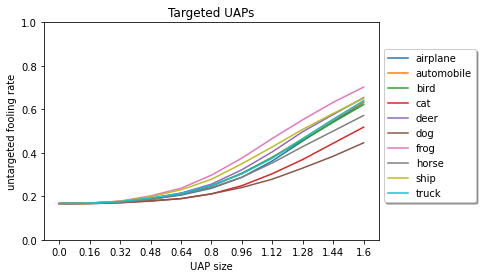

In [57]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Add title and axis names
plt.title('Targeted UAPs')
plt.xlabel('UAP size')
plt.ylabel('untargeted fooling rate')
plt.ylim(0,1)

xrange = [float(f'{1.6*i/10:.2f}') for i in range(11)]

#ploting the graphs
for i in range(10):
  line = [item[0] for item in eval_dict[i*11:i*11+11]]
  plt.plot(line, label = classes[i])
  plt.xticks(np.arange(len(xrange)), xrange)
plt.legend(bbox_to_anchor=(1, 0.9), shadow=True, fancybox=True)
plt.show

<function matplotlib.pyplot.show>

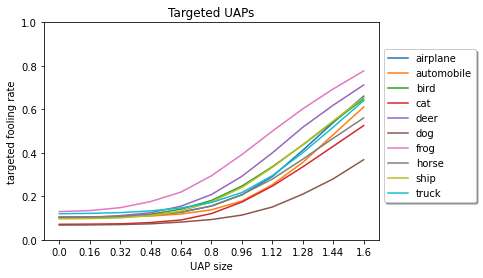

In [58]:
# Add title and axis names
plt.title('Targeted UAPs')
plt.xlabel('UAP size')
plt.ylabel('targeted fooling rate')
plt.ylim(0,1)

xrange = [float(f'{1.6*i/10:.2f}') for i in range(11)]

#ploting the graphs
for i in range(10):
  line = [item[1] for item in eval_dict[i*11:i*11+11]]
  plt.plot(line, label = classes[i])
  plt.xticks(np.arange(len(xrange)), xrange)
plt.legend(bbox_to_anchor=(1, 0.9), shadow=True, fancybox=True)
plt.show

## Experiment 2
specific source-target attack.

our general porpose of this experiment is to combine 2 different TUAPs and to analyze the effect of 3 different combining methods.

---



*   we create 2 TUAPs: 
  1. will take deer class into horse class
  2. will take bird class into airplane class

*   we evaluate the resulted TUAPs  

*   we use 3 different combining methods:
  1. grid mask that splits the input space
  2. one TUAP will get the top half and the other will get the bottom half
  3. combining by using new gradient attack that combines both constrains


*   we evaluate and compre the 3 methods


*   we visuelize the effect with conffusion matrix



In [16]:
# now we create a specific source-target attack that sends only deer->horse
train_set_x = img_val[4][:200]
train_labels = y_val[4][:200]
train_labels = np.argmax(train_labels,axis=-1)
#turn class 4 to 7
train_labels = np.where(train_labels==4,7,train_labels)

train_set_x,train_labels = shuffle(train_set_x,train_labels)
batch_size = 32
TUAP_47 = targetedUAP2(model, train_set_x, to_categorical(train_labels, 10),batch_size, iterations=10, epsilon=1.6, step=0.006)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.variables_initializer` instead.
Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.

Epoch: 1,
Moved into target class: 0.8100000023841858,
UAP Size: 1.5999999999999999
Epoch: 2,
Moved into target class: 0.8199999928474426,
UAP Size: 1.6
Epoch: 3,
Moved into target class: 0.8450000286102295,
UAP Size: 1.6
Epoch: 4,
Moved into target class: 0.8299999833106995,
UAP Size: 1.6
Epoch: 5,
Moved into target class: 0.8199999928474426,
UAP Size: 1.6


In [20]:
mal_target = np.zeros(y_val[4].shape[0])
mal_target[:] = 7
mal_target = keras.utils.to_categorical(mal_target, 10)
uFR, tFR = eval_targeted_uap(model,img_val[4]+TUAP_47,y_val[4],mal_target)
print(f'results for TUAP 4->7 specific class: untargeted FR = {uFR}, targeted FR = {tFR}')

results for TUAP 4->7 specific class: untargeted FR = 0.8751020431518555, targeted FR = 0.7659183740615845


In [28]:
rest_img, rest_label = getEvalData(x_test,y_test,4)
mal_target = np.zeros(rest_label.shape[0])
mal_target[:] = 7
mal_target = keras.utils.to_categorical(mal_target, 10)
uFR, tFR = eval_targeted_uap(model,rest_img+TUAP_47,to_categorical(rest_label,10),mal_target)
print(f'results for TUAP 4->7 leak effect: untargeted FR = {uFR}')

results for TUAP 4->7 leak effect: untargeted FR = 0.5247777700424194


In [29]:
# now we create a specific source-target attack that sends only bird->airplane
train_set_x = img_val[2][:200]
train_labels = y_val[2][:200]
train_labels = np.argmax(train_labels,axis=-1)
#turn class 2 to 0
train_labels = np.where(train_labels==2,0,train_labels)

train_set_x,train_labels = shuffle(train_set_x,train_labels)
batch_size = 32
TUAP_20 = targetedUAP2(model, train_set_x, to_categorical(train_labels, 10),batch_size, iterations=10, epsilon=1.6, step=0.006)


Epoch: 1,
Moved into target class: 0.8849999904632568,
UAP Size: 1.6
Epoch: 2,
Moved into target class: 0.9200000166893005,
UAP Size: 1.5999999999999999
Epoch: 3,
Moved into target class: 0.9300000071525574,
UAP Size: 1.6
Epoch: 4,
Moved into target class: 0.9300000071525574,
UAP Size: 1.6
Epoch: 5,
Moved into target class: 0.9150000214576721,
UAP Size: 1.6


In [33]:
mal_target = np.zeros(y_val[2].shape[0])
mal_target[:] = 0
mal_target = keras.utils.to_categorical(mal_target, 10)
uFR, tFR = eval_targeted_uap(model,img_val[2]+TUAP_20,y_val[2],mal_target)
print(f'results for TUAP 2->0 specific class: untargeted FR = {uFR}, targeted FR = {tFR}')

results for TUAP 2->0 specific class: untargeted FR = 0.9177551046013832, targeted FR = 0.8706122636795044


In [32]:
rest_img, rest_label = getEvalData(x_test,y_test,2)
mal_target = np.zeros(rest_label.shape[0])
mal_target[:] = 0
mal_target = keras.utils.to_categorical(mal_target, 10)
uFR, tFR = eval_targeted_uap(model,rest_img+TUAP_20,to_categorical(rest_label,10),mal_target)
print(f'results for TUAP 2->0 leak effect: untargeted FR = {uFR}')

results for TUAP 2->0 leak effect: untargeted FR = 0.5488888919353485


In [64]:
def gridCombine(uap1,uap2):
  # create random mask
  a = np.zeros((3072))
  b = random.sample(range(3072), 1536)
  a[b] = 1
  mask1 = np.reshape(a,(32,32,3))
  mask2 = np.reshape((1-a),(32,32,3))
  #combining with the masked uaps
  combind_uap = mask1*uap1+mask2*uap2
  return combind_uap

def regionCombine(uap1,uap2):
  #create the region mask: left maks1 right mask2
  mask1 = np.zeros((32,32,3))
  mask2 = np.zeros((32,32,3))
  for i in range(32):
    for j in range(32):
      if j>=16:
        mask2[i,j,:] = 1
      else: mask1[i,j,:] = 1
  #combining with the masked uaps
  combind_uap = mask1*uap1+mask2*uap2
  return combind_uap


create the grid combined uap and evaluate it

In [52]:
# combine by grid method
TUAP_gridComb_42 = gridCombine(TUAP_20, TUAP_47)

In [53]:
# eval the resulted combine uap

img_validation = np.concatenate((img_val[2],img_val[4]))
label_validation = np.concatenate((y_val[2],y_val[4]))
mal_target = np.zeros(label_validation.shape[0])
mal_target[:4900] = 0
mal_target[4900:] = 7
mal_target = keras.utils.to_categorical(mal_target, 10)
uFR, tFR = eval_targeted_uap(model,img_validation+TUAP_gridComb_42,label_validation,mal_target)
print(f'results for multi class targeted uap 4+2 specific class: untargeted FR = {uFR}, targeted FR = {tFR}')

results for multi class targeted uap 4+2 specific class: untargeted FR = 0.40551018714904785, targeted FR = 0.06438775360584259


In [54]:
rest_img, rest_label = getEvalData(x_test,y_test,2)
rest_img, rest_label = getEvalData(rest_img,rest_label,4)
mal_target = np.zeros(rest_label.shape[0])
mal_target[:] = 0
mal_target = keras.utils.to_categorical(mal_target, 10)
uFR, tFR = eval_targeted_uap(model,rest_img+TUAP_gridComb_42,to_categorical(rest_label,10),mal_target)
print(f'results for TUAP 2->0 leak effect: untargeted FR = {uFR}')

results for TUAP 2->0 leak effect: untargeted FR = 0.29587501287460327


create the region combine uap and evaluate it

In [65]:
# combine by grid method
TUAP_regionComb_42 = regionCombine(TUAP_20, TUAP_47)

In [67]:
# eval the resulted combine uap

img_validation = np.concatenate((img_val[2],img_val[4]))
label_validation = np.concatenate((y_val[2],y_val[4]))
mal_target = np.zeros(label_validation.shape[0])
mal_target[:4900] = 0
mal_target[4900:] = 7
mal_target = keras.utils.to_categorical(mal_target, 10)
uFR, tFR = eval_targeted_uap(model,img_validation+TUAP_regionComb_42,label_validation,mal_target)
print(f'results for multi class targeted uap 4+2 specific class: untargeted FR = {uFR}, targeted FR = {tFR}')

results for multi class targeted uap 4+2 specific class: untargeted FR = 0.8485714346170425, targeted FR = 0.427142858505249


In [68]:
rest_img, rest_label = getEvalData(x_test,y_test,2)
rest_img, rest_label = getEvalData(rest_img,rest_label,4)
mal_target = np.zeros(rest_label.shape[0])
mal_target[:] = 0
mal_target = keras.utils.to_categorical(mal_target, 10)
uFR, tFR = eval_targeted_uap(model,rest_img+TUAP_regionComb_42,to_categorical(rest_label,10),mal_target)
print(f'results for TUAP 2->0 leak effect: untargeted FR = {uFR}')

results for TUAP 2->0 leak effect: untargeted FR = 0.43037497997283936


create a combined uap by entire new training with both constrains

In [78]:
# now we create a specific source-target attack that sends bird->airplane & deer->horse
train_set_x = np.concatenate((img_val[2][:200],img_val[4][:200]))
train_labels = np.concatenate((y_val[2][:200],y_val[2][:200]))
train_labels = np.argmax(train_labels,axis=-1)
#turn class 2 to 0 and 4 to 7
train_labels = np.where(train_labels==2,0,train_labels)
train_labels = np.where(train_labels==4,7,train_labels)

train_set_x,train_labels = shuffle(train_set_x,train_labels)
batch_size = 32
TUAP_gradComb_42 = targetedUAP2(model, train_set_x, to_categorical(train_labels, 10),batch_size, iterations=10, epsilon=1.6, step=0.006)

Epoch: 1,
Moved into target class: 0.8349999785423279,
UAP Size: 1.6
Epoch: 2,
Moved into target class: 0.8525000214576721,
UAP Size: 1.6000000000000003
Epoch: 3,
Moved into target class: 0.8324999809265137,
UAP Size: 1.6
Epoch: 4,
Moved into target class: 0.8550000190734863,
UAP Size: 1.6
Epoch: 5,
Moved into target class: 0.8475000262260437,
UAP Size: 1.6


In [79]:
# eval the resulted combine uap

img_validation = np.concatenate((img_val[2],img_val[4]))
label_validation = np.concatenate((y_val[2],y_val[4]))
mal_target = np.zeros(label_validation.shape[0])
mal_target[:4900] = 0
mal_target[4900:] = 7
mal_target = keras.utils.to_categorical(mal_target, 10)
uFR, tFR = eval_targeted_uap(model,img_validation+TUAP_gradComb_42,label_validation,mal_target)
print(f'results for multi class targeted uap 4+2 specific class: untargeted FR = {uFR}, targeted FR = {tFR}')

results for multi class targeted uap 4+2 specific class: untargeted FR = 0.887346938252449, targeted FR = 0.44091835618019104


In [80]:
rest_img, rest_label = getEvalData(x_test,y_test,2)
rest_img, rest_label = getEvalData(rest_img,rest_label,4)
mal_target = np.zeros(rest_label.shape[0])
mal_target[:] = 0
mal_target = keras.utils.to_categorical(mal_target, 10)
uFR, tFR = eval_targeted_uap(model,rest_img+TUAP_gradComb_42,to_categorical(rest_label,10),mal_target)
print(f'results for TUAP 2->0 leak effect: untargeted FR = {uFR}')

results for TUAP 2->0 leak effect: untargeted FR = 0.5633749961853027


now we will try to get more insights by visualize the confusion matrix of our combined uaps

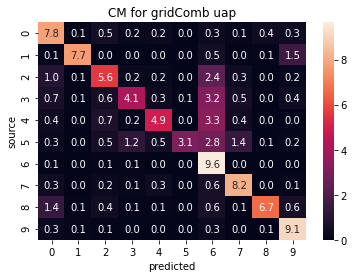

In [82]:
# CM for the grid combine:
y_true = y_test
y_pred = np.argmax(model.predict(x_test+TUAP_gridComb_42), axis=-1)
CM = np.array(confusion_matrix(y_true, y_pred)/100,dtype=np.float32)
sn.heatmap(CM,fmt='.1f', annot=True)

plt.title('CM for gridComb uap')
plt.xlabel('predicted')
plt.ylabel('source')

plt.show()

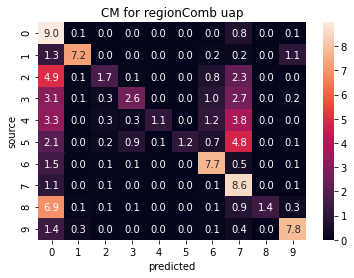

In [83]:
# CM for the region combine:
y_true = y_test
y_pred = np.argmax(model.predict(x_test+TUAP_regionComb_42), axis=-1)
CM = np.array(confusion_matrix(y_true, y_pred)/100,dtype=np.float32)
sn.heatmap(CM,fmt='.1f', annot=True)
plt.title('CM for regionComb uap')
plt.xlabel('predicted')
plt.ylabel('source')
plt.show()

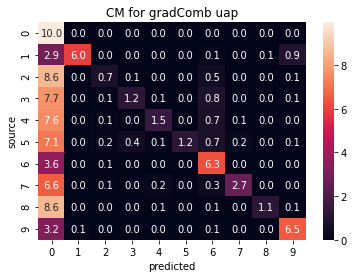

In [84]:
# CM for the gradient combine:
y_true = y_test
y_pred = np.argmax(model.predict(x_test+TUAP_gradComb_42), axis=-1)
CM = np.array(confusion_matrix(y_true, y_pred)/100,dtype=np.float32)
sn.heatmap(CM,fmt='.1f', annot=True)
plt.title('CM for gradComb uap')
plt.xlabel('predicted')
plt.ylabel('source')
plt.show()